In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from random import seed
from scipy import stats
import seaborn as sns
import pingouin as pg
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
import statsmodels.api as sm
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols
from statsmodels.regression import linear_model
from sklearn.metrics import explained_variance_score
%matplotlib inline

seed(888)
pd.set_option('display.max_columns', None)

# 1 Load data from "3. BrainAge"

In [46]:
# load data from pickle and convert to dataframe
brain_test = pd.read_pickle("3_brain_test.pkl")
brain_train = pd.read_pickle("3_brain_train.pkl")
main_test = pd.read_pickle("3_main_test.pkl")
main_train = pd.read_pickle("3_main_train.pkl")
brain_test = pd.DataFrame(brain_test)
brain_train = pd.DataFrame(brain_train)
main_test = pd.DataFrame(main_test)
main_train = pd.DataFrame(main_train)

# 2 Basic distributions

## 2.1 Data

In [47]:
main_test.head()

,Age,Gender,TPA,VPA,MPA,MVPA,LPA,BMI,ECGW,ECGHR,SRLPA,SRMPA,SRVPA,FI,HGL,HGR,IS,Smoking,SES,HR,JPA,DBP,SBP,WS,Excluded,BADA2009,BADASEG,BADDesikan,BADAll
2,73.0,Female,2550.2400,10.0800,352.8000,372.9600,2187.3600,26.9,NaN,NaN,1188.0,120.0,0.0,9.0,20.0,26.0,11025,No,-3.469800,57.0,NaN,82.0,142.0,Steady average pace,0,8.601317,15.110047,-4.012368,5.692717
6,67.0,Male,1302.9120,0.0000,100.2240,100.2240,1202.6880,34.2,NaN,NaN,330.0,2880.0,1080.0,4.0,42.0,36.0,11025,No,-2.203830,76.0,Sometimes,67.0,100.0,Steady average pace,1,-16.241672,4.132547,-31.234663,-7.268007
12,56.0,Male,1601.3088,18.9504,227.4048,265.3056,1354.9536,28.4,120.0,117.0,396.0,900.0,0.0,NaN,35.0,39.0,11025,No,0.642148,60.0,Never/rarely,96.0,157.0,Brisk pace,1,3.824066,-3.116006,4.695864,-1.735580
21,56.0,Female,2465.2224,29.1168,427.0464,485.2800,2009.0592,33.6,NaN,NaN,2970.0,720.0,240.0,NaN,18.0,18.0,11025,No,-5.554810,49.0,Sometimes,75.0,134.0,Steady average pace,1,-3.948342,-11.017045,19.069531,-5.116799
25,70.0,Female,2746.1376,10.0224,210.4704,230.5152,2525.6448,22.1,NaN,NaN,2772.0,240.0,320.0,NaN,22.0,20.0,11026,No,-0.812078,60.0,NaN,87.0,170.0,Steady average pace,0,-10.480420,-20.101903,-6.494201,-14.503003


## 2.2 Train vs. Test

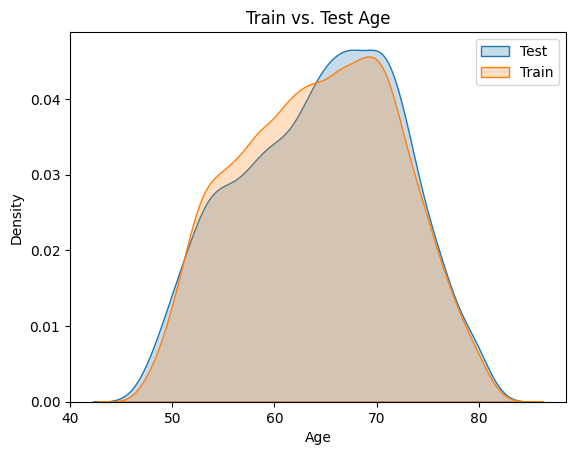

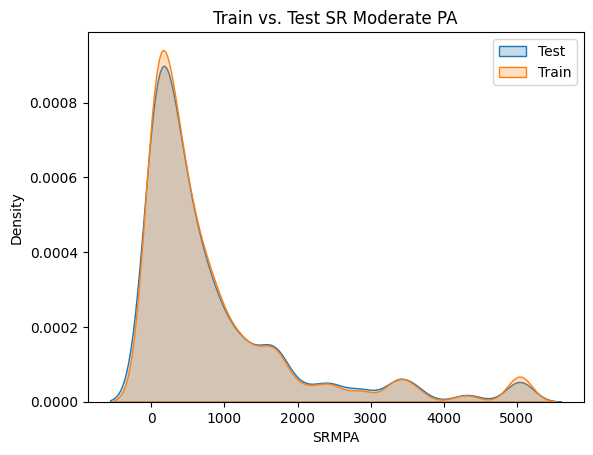

Test Gender Female    4632
Male      3725
Name: Gender, dtype: int64
Train Gender Female    7855
Male      6727
Name: sex_f31_0_0, dtype: int64


In [48]:
plt.figure()
sns.kdeplot(data = main_test, x= 'Age', fill=True, label = "Test")
sns.kdeplot(data = main_train, x= 'Age', fill=True, label = "Train")
plt.legend()
plt.title("Train vs. Test Age")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRMPA', fill=True, label = "Test")
sns.kdeplot(x= main_train.iloc[:,9990], fill=True, label = "Train")
plt.legend()
plt.title("Train vs. Test SR Moderate PA")
plt.show()

print("Test Gender", main_test["Gender"].value_counts())
print("Train Gender", main_train.iloc[:,22].value_counts())

## 2.3 Age and BrainAge

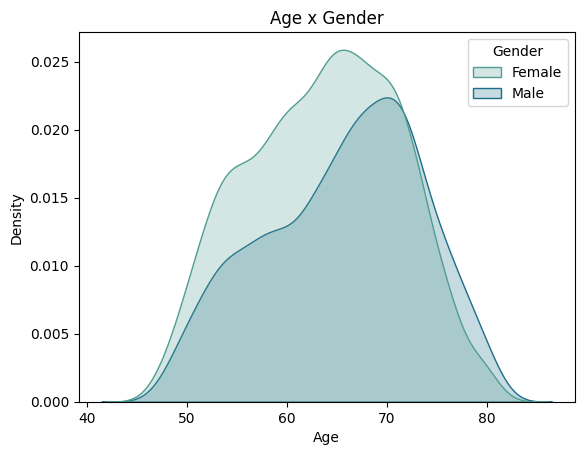

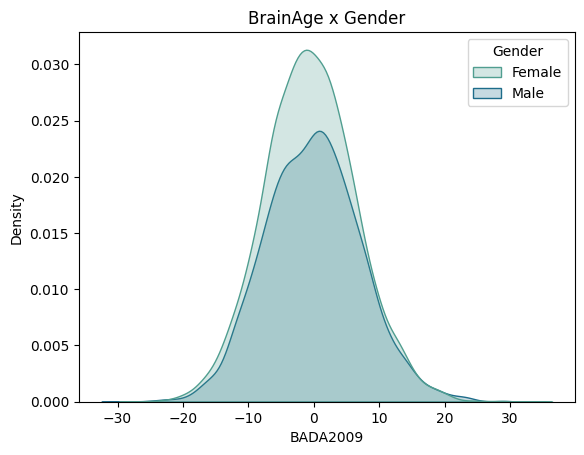

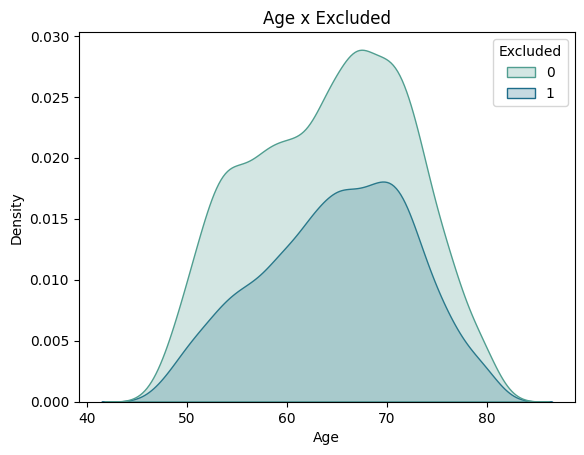

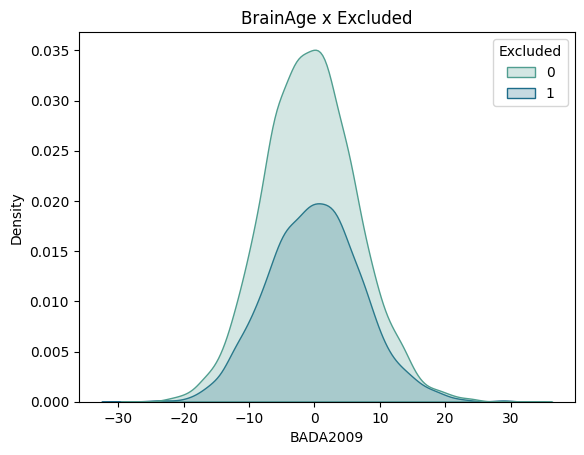

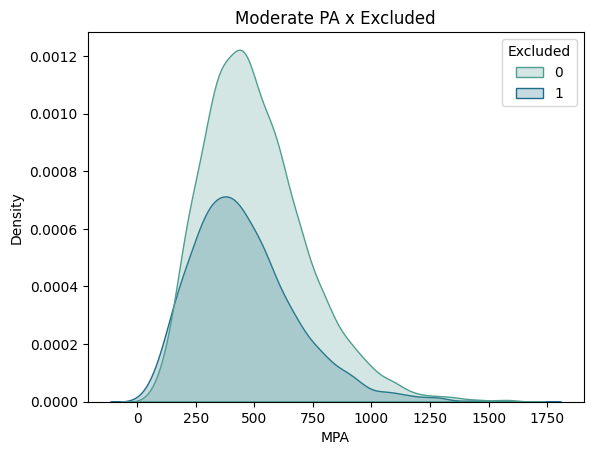

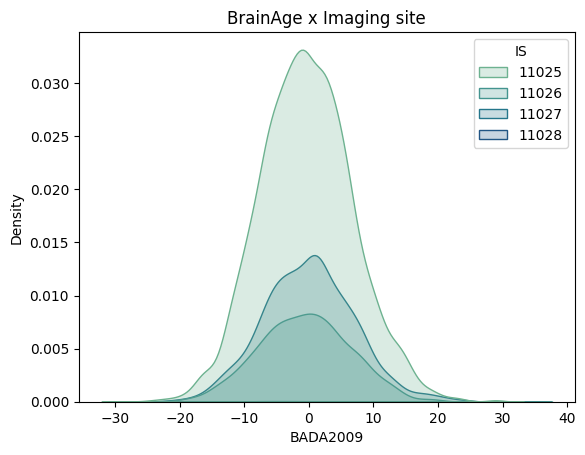

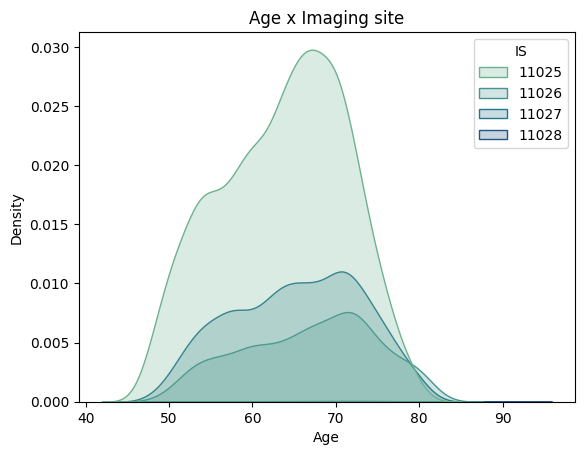

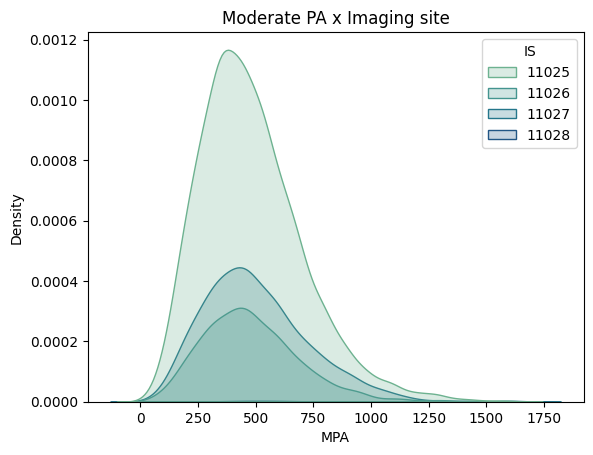

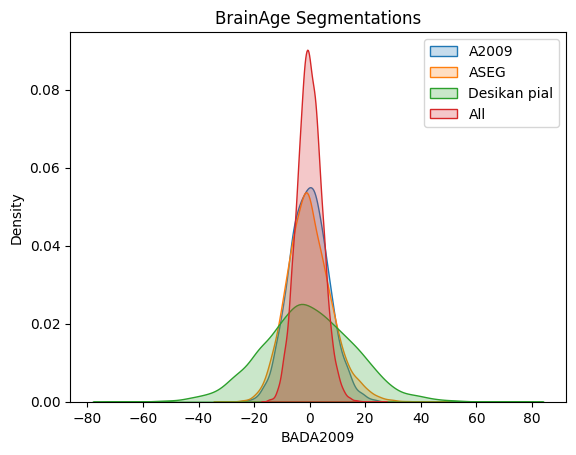

In [49]:
plt.figure()
sns.kdeplot(data = main_test, x= 'Age', hue = 'Gender', fill=True, palette = "crest")
plt.title("Age x Gender")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'BADA2009', hue = 'Gender', fill=True, palette = "crest")
plt.title("BrainAge x Gender")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'Age', hue = 'Excluded', fill=True, palette = "crest")
plt.title("Age x Excluded")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'BADA2009', hue = 'Excluded', fill=True, palette = "crest")
plt.title("BrainAge x Excluded")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'MPA', hue = 'Excluded', fill=True, palette = "crest")
plt.title("Moderate PA x Excluded")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'BADA2009', hue = 'IS', fill=True, palette = "crest")
plt.title("BrainAge x Imaging site")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'Age', hue = 'IS', fill=True, palette = "crest")
plt.title("Age x Imaging site")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'MPA', hue = 'IS', fill=True, palette = "crest")
plt.title("Moderate PA x Imaging site")
plt.show()


plt.figure()
sns.kdeplot(data = main_test, x= 'BADA2009', fill=True, label="A2009")
sns.kdeplot(data = main_test, x= 'BADASEG', fill=True, label="ASEG")
sns.kdeplot(data = main_test, x= 'BADDesikan', fill=True, label="Desikan pial")
sns.kdeplot(data = main_test, x= 'BADAll', fill=True, label="All")
plt.title("BrainAge Segmentations")
plt.legend()
plt.show()

## 2.4 Physical activity

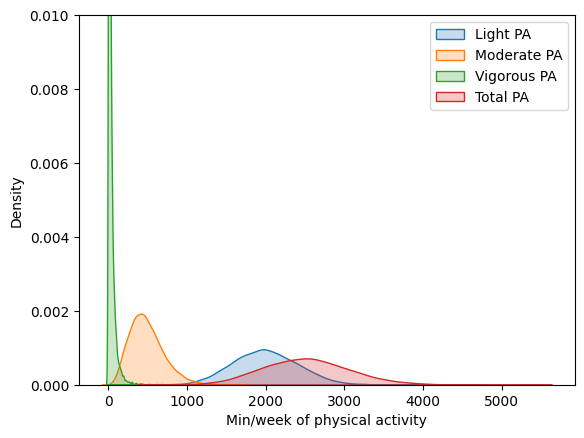

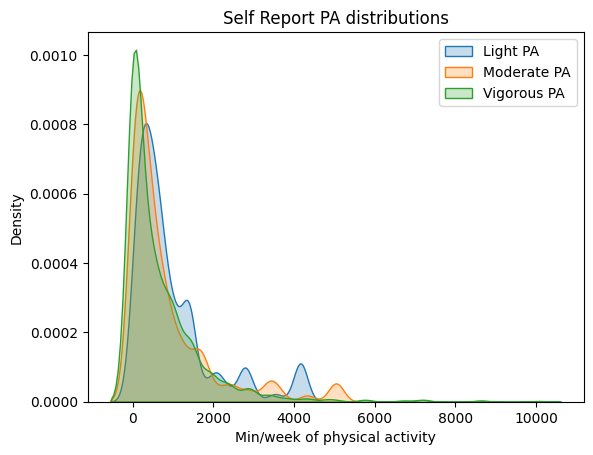

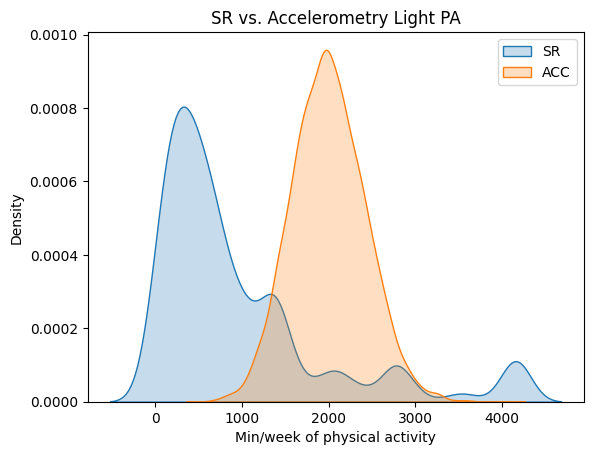

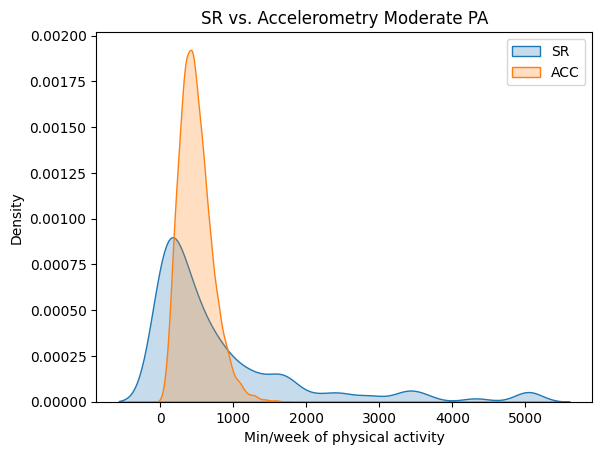

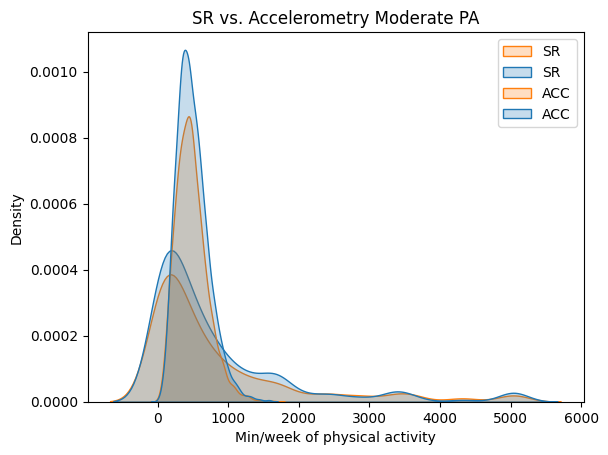

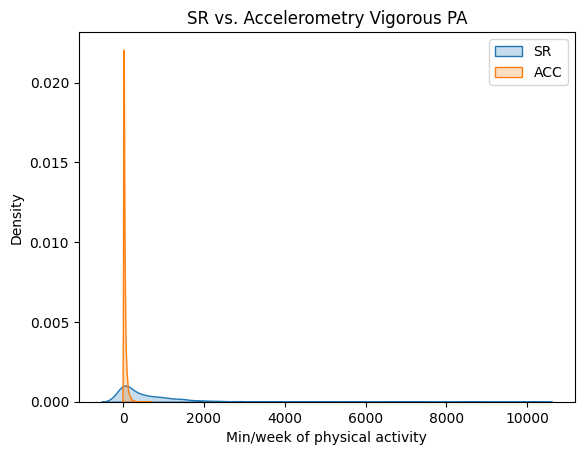

In [50]:
plt.figure()
sns.kdeplot(data = main_test, x= 'LPA', fill=True, label = "Light PA")
sns.kdeplot(data = main_test, x= 'MPA', fill=True, label = "Moderate PA")
sns.kdeplot(data = main_test, x= 'VPA', fill=True, label = "Vigorous PA")
sns.kdeplot(data = main_test, x= 'TPA', fill=True, label = "Total PA")
plt.xlabel("Min/week of physical activity")
plt.legend()
plt.ylim(0,0.01)
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRLPA', fill=True, label = "Light PA")
sns.kdeplot(data = main_test, x= 'SRMPA', fill=True, label = "Moderate PA")
sns.kdeplot(data = main_test, x= 'SRVPA', fill=True, label = "Vigorous PA")
plt.xlabel("Min/week of physical activity")
plt.title("Self Report PA distributions")
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRLPA', fill=True, label = "SR")
sns.kdeplot(data = main_test, x= 'LPA', fill=True, label = "ACC")
plt.xlabel("Min/week of physical activity")
plt.title("SR vs. Accelerometry Light PA")
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRMPA', fill=True, label = "SR")
sns.kdeplot(data = main_test, x= 'MPA', fill=True, label = "ACC")
plt.xlabel("Min/week of physical activity")
plt.title("SR vs. Accelerometry Moderate PA")
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRMPA', hue = "Gender", fill=True, label = "SR")
sns.kdeplot(data = main_test, x= 'MPA', hue = "Gender", fill=True, label = "ACC")
plt.xlabel("Min/week of physical activity")
plt.title("SR vs. Accelerometry Moderate PA")
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRVPA', fill=True, label = "SR")
sns.kdeplot(data = main_test, x= 'VPA', fill=True, label = "ACC")
plt.xlabel("Min/week of physical activity")
plt.title("SR vs. Accelerometry Vigorous PA")
plt.legend()
plt.show()

## 2.5 Fitness

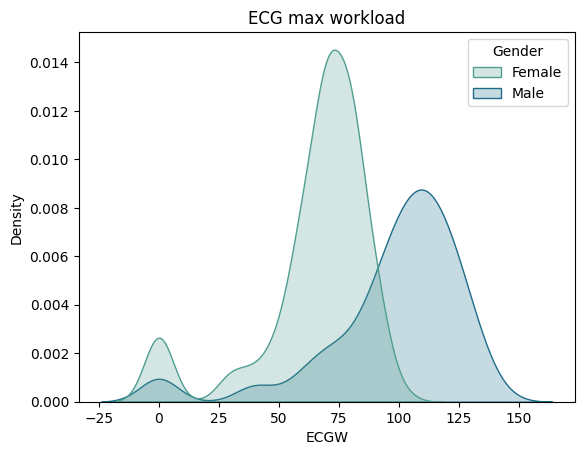

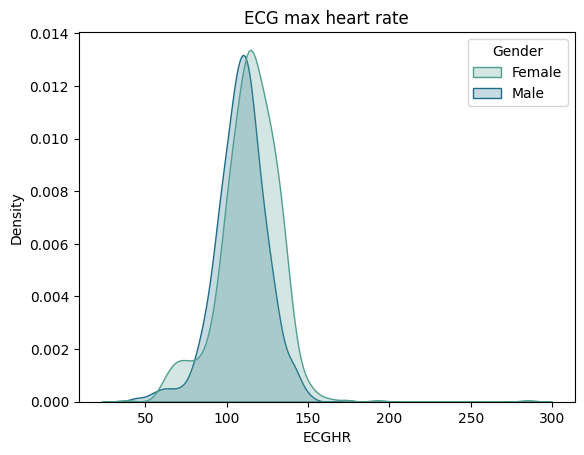

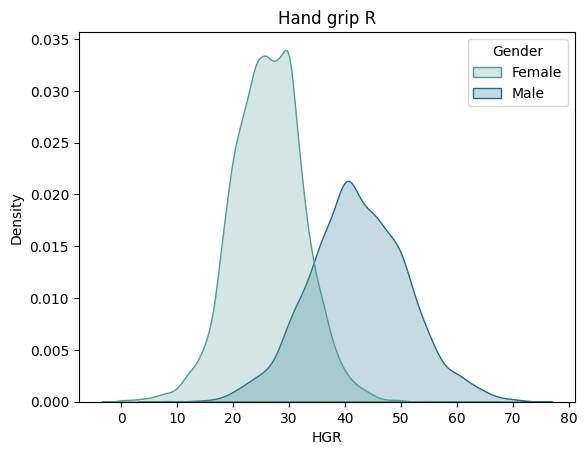

Walking speed: Brisk pace              4301
Steady average pace     3825
Slow pace                213
None of the above          7
Prefer not to answer       1
Name: WS, dtype: int64


In [51]:
plt.figure()
sns.kdeplot(data = main_test, x= 'ECGW', hue = 'Gender', fill=True, palette = "crest")
plt.title("ECG max workload")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'ECGHR', hue = 'Gender', fill=True, palette = "crest")
plt.title("ECG max heart rate")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'HGR', hue = 'Gender', fill=True, palette = "crest")
plt.title("Hand grip R")
plt.show()

print("Walking speed:", main_test["WS"].value_counts())

## 2.6 Health

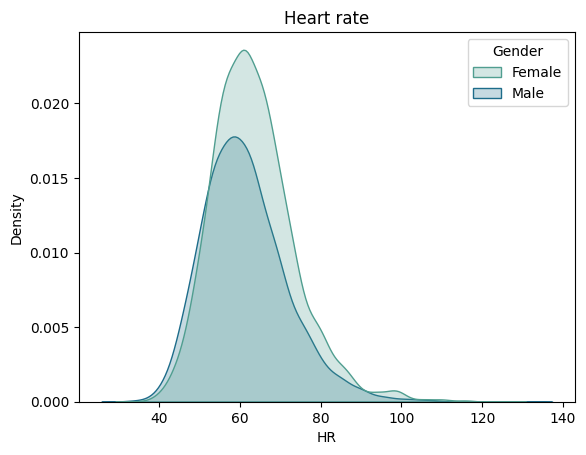

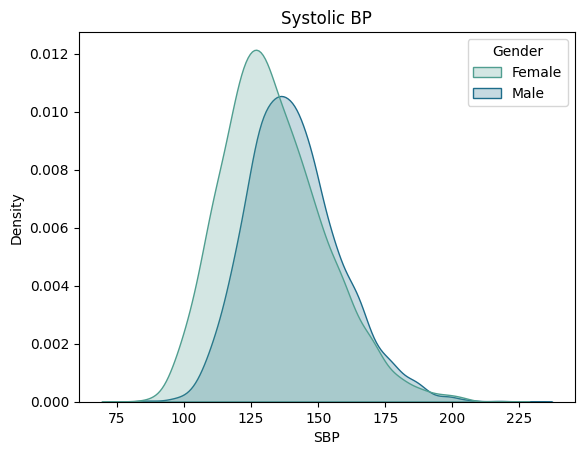

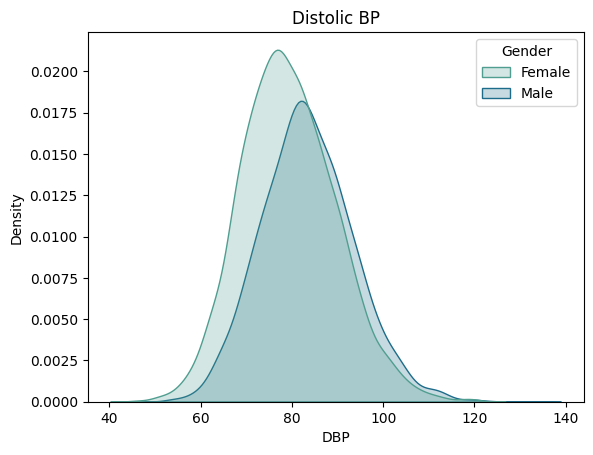

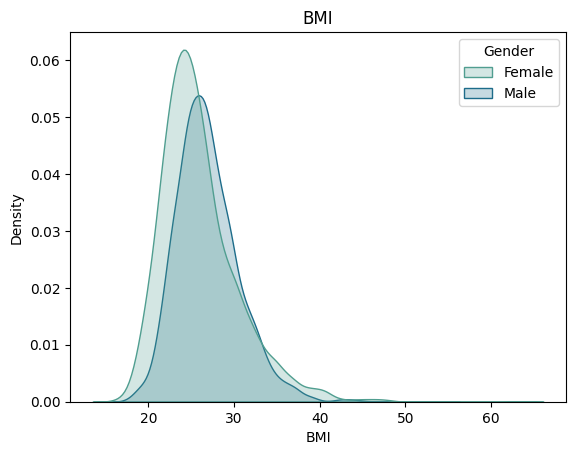

In [52]:
plt.figure()
sns.kdeplot(data = main_test, x= 'HR', hue = 'Gender', fill=True, palette = "crest")
plt.title("Heart rate")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SBP', hue = 'Gender', fill=True, palette = "crest")
plt.title("Systolic BP")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'DBP', hue = 'Gender', fill=True, palette = "crest")
plt.title("Distolic BP")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'BMI', hue = 'Gender', fill=True, palette = "crest")
plt.title("BMI")
plt.show()

## 2.7 Other variables

Smoking: No                          7902
Yes, on most or all days     289
Only occasionally            163
Prefer not to answer           1
Name: Smoking, dtype: int64
Job PA: Never/rarely            4136
Sometimes                970
Usually                  250
Always                   217
Do not know                1
Prefer not to answer       0
Name: JPA, dtype: int64


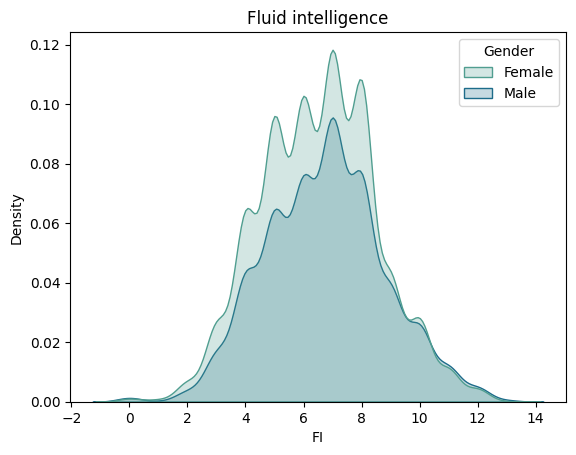

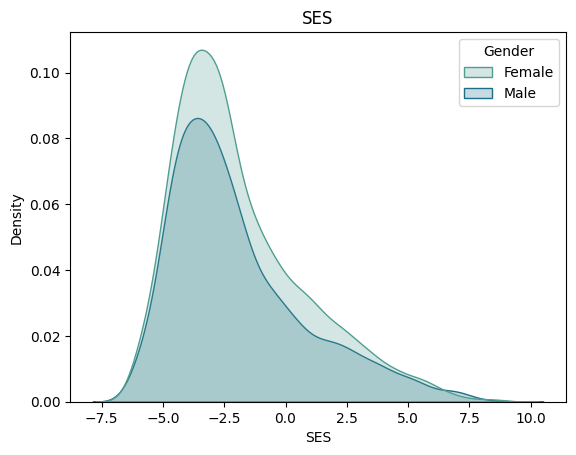

In [53]:
print("Smoking:", main_test["Smoking"].value_counts())
print("Job PA:", main_test["JPA"].value_counts())

plt.figure()
sns.kdeplot(data = main_test, x= 'FI', hue = 'Gender', fill=True, palette = "crest")
plt.title("Fluid intelligence")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SES', hue = 'Gender', fill=True, palette = "crest")
plt.title("SES")
plt.show()

# 3 Recode variables

In [54]:
# 1 = Cheadle;  2 = Reading;  3 = Newcastle;  4 = Bristol
main_test['IS'] = main_test['IS'].map({'11025': 1, '11026': 2,'11027': 3, '11028': 4})
main_test["Smoking"] = main_test["Smoking"].map({"No":0, "Only occasionally":1, "Yes, on most or all days":2})
main_test["Gender"] = main_test["Gender"].map({"Female":0, "Male":1})
main_test["Gender"] = main_test["Gender"].astype("int")
main_test["JPA"] = main_test["JPA"].map({"Never/rarely":0, "Sometimes":1, "Usually":2,"Always":3})
main_test["WS"] = main_test["WS"].map({"Slow pace":0, "Steady average pace":1, "Brisk pace":2})

del main_test["BADDesikan"]
del main_test["BADASEG"]

main_test = main_test.rename(columns={"BADA2009": "BA"})

main_test = pd.DataFrame(main_test)


# 4 Simple correlation heatmap

Text(0.5, 1.0, 'Correlations All')

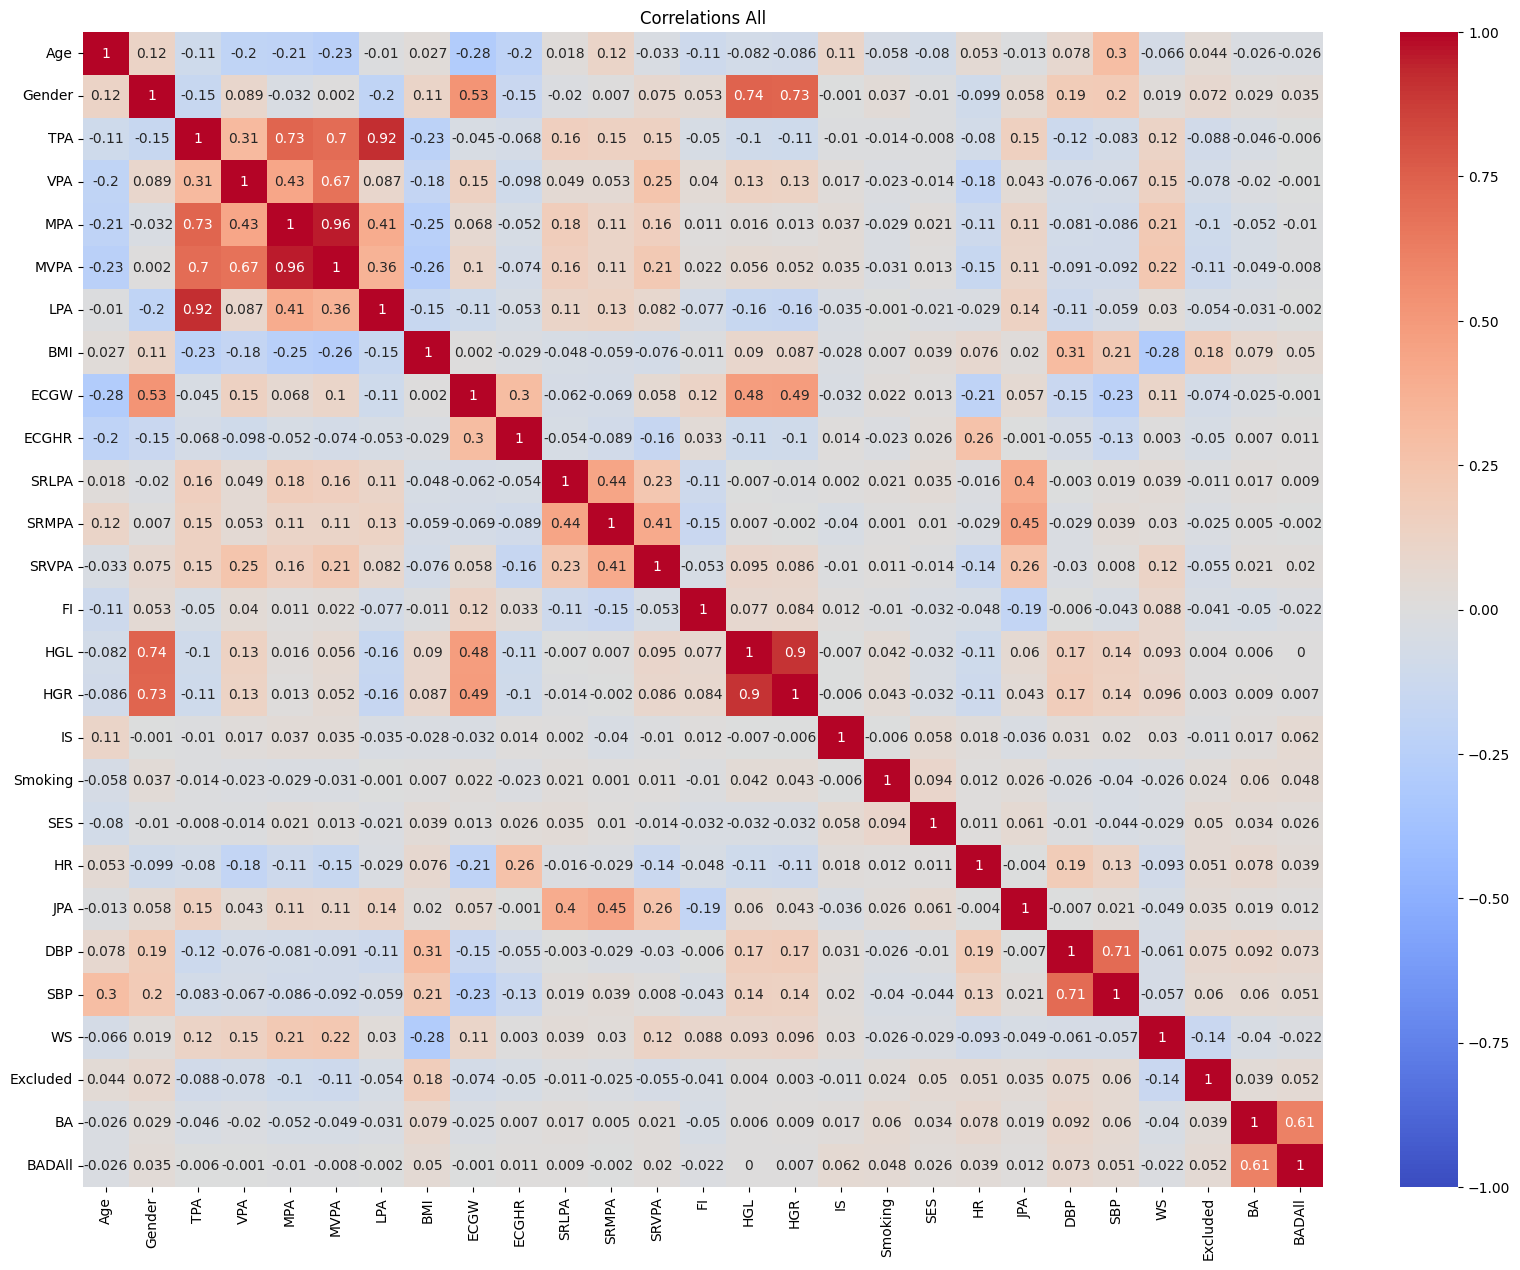

In [55]:
corr = main_test.corr()
corr = round(corr,3)
fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(corr, annot=True, cmap = "coolwarm", vmin=-1, vmax=1)
plt.title("Correlations All")

# 5 Partial correlations with Covariates

In [56]:
cov_correlation = pg.partial_corr(data=main_test, x='SRLPA', y='BA', covar=["Gender", "IS", "Age"])
print("SR Light PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='SRMPA', y='BA', covar=["Gender", "IS", "Age"])
print("SR Moderate PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='SRVPA', y='BA', covar=["Gender", "IS", "Age"])
print("SR Vigorous PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='TPA', y='BA', covar=["Gender", "IS", "Age"])
print("Total PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='LPA', y='BA', covar=["Gender", "IS", "Age"])
print("Light PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='MPA', y='BA', covar=["Gender", "IS", "Age"])
print("Moderate PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='VPA', y='BA', covar=["Gender", "IS", "Age"])
print("Vigorous PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='MVPA', y='BA', covar=["Gender", "IS", "Age"])
print("Moderate+Vigorous PA")
print(cov_correlation)

SR Light PA
            n         r         CI95%     p-val
pearson  7156  0.018635  [-0.0, 0.04]  0.115042
SR Moderate PA
            n         r          CI95%     p-val
pearson  7156  0.009238  [-0.01, 0.03]  0.434715
SR Vigorous PA
            n         r          CI95%     p-val
pearson  7156  0.018059  [-0.01, 0.04]  0.126719
Total PA
            n         r           CI95%     p-val
pearson  8357 -0.044461  [-0.07, -0.02]  0.000048
Light PA
            n         r          CI95%     p-val
pearson  8357 -0.024654  [-0.05, -0.0]  0.024237
Moderate PA
            n         r           CI95%         p-val
pearson  8357 -0.060284  [-0.08, -0.04]  3.503757e-08
Vigorous PA
            n         r           CI95%     p-val
pearson  8357 -0.030592  [-0.05, -0.01]  0.005169
Moderate+Vigorous PA
            n         r           CI95%         p-val
pearson  8357 -0.059556  [-0.08, -0.04]  5.109546e-08


# 6 Models OLS

## 6.1 Covariates

In [57]:
cov_model = ols('BA ~ Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(cov_model.summary())

#calculate effect size
results = cov_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     7.054
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           1.66e-07
Time:                        12:03:18   Log-Likelihood:                -28267.
No. Observations:                8357   AIC:                         5.655e+04
Df Residuals:                    8350   BIC:                         5.660e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8470      1.551      3.769      0.0

## 6.2 Accelerometer PA

In [58]:
pa_model = ols('BA ~ LPA + MPA + VPA + Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(pa_model.summary())

#calculate effect size
results = pa_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     8.114
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           4.41e-12
Time:                        12:03:18   Log-Likelihood:                -28252.
No. Observations:                8357   AIC:                         5.652e+04
Df Residuals:                    8347   BIC:                         5.659e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3799      1.602      4.608      0.0

## 6.3 Self-report PA

In [59]:
sr_model = ols('BA ~ SRLPA + SRMPA + SRVPA +Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(sr_model.summary())

#calculate effect size
results = sr_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.660
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           3.51e-06
Time:                        12:03:18   Log-Likelihood:                -24198.
No. Observations:                7156   AIC:                         4.842e+04
Df Residuals:                    7146   BIC:                         4.848e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8423      1.683      3.471      0.0

## 6.4 Accelerometer + Self-report PA

In [60]:
sr_pa_model = ols('BA ~ SRLPA + SRMPA + SRVPA +LPA + MPA + VPA+ Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(sr_pa_model.summary())
results = sr_pa_model
coefficients = results.params
t_stats = results.tvalues

#calculate effect size
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     5.832
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           3.66e-10
Time:                        12:03:18   Log-Likelihood:                -24184.
No. Observations:                7156   AIC:                         4.839e+04
Df Residuals:                    7143   BIC:                         4.848e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3426      1.732      4.238      0.0

## 6.5 Fitness

In [61]:
fitness = ols('BA ~ HGR + HGL + ECGW + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(fitness.summary())

#calculate effect size
results = fitness
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     3.390
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           0.000396
Time:                        12:03:18   Log-Likelihood:                -4736.5
No. Observations:                1412   AIC:                             9493.
Df Residuals:                    1402   BIC:                             9545.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.7519      5.068      3.503      0.0

## 6.6 Health

In [62]:
health = ols('BA ~ ECGHR + SBP + HR + DBP + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(health.summary())

#calculate effect size
results = health
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3.127
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           0.000593
Time:                        12:03:19   Log-Likelihood:                -3964.9
No. Observations:                1186   AIC:                             7952.
Df Residuals:                    1175   BIC:                             8008.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2516      5.703      0.921      0.3

## 6.7 Health and Fitness

In [63]:
he_fi = ols('BA ~ HGR + SBP + HR + DBP + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(he_fi.summary())

#calculate effect size
results = he_fi
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     11.41
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           1.22e-19
Time:                        12:03:19   Log-Likelihood:                -22230.
No. Observations:                6579   AIC:                         4.448e+04
Df Residuals:                    6568   BIC:                         4.456e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9240      1.936      0.477      0.6

## 6.8 Other variables

In [64]:
other = ols('BA ~ FI + Smoking + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(other.summary())

#calculate effect size
results = other
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     8.219
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           3.98e-11
Time:                        12:03:19   Log-Likelihood:                -20014.
No. Observations:                5924   AIC:                         4.005e+04
Df Residuals:                    5915   BIC:                         4.011e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4583      1.867      2.923      0.0

# 7 Model comparisons

## 7.1 Cov x PA

In [65]:
model_comparison = anova_lm(cov_model, pa_model)
print(model_comparison)

   df_resid            ssr  df_diff      ss_diff          F    Pr(>F)
0    8350.0  424155.388689      0.0          NaN        NaN       NaN
1    8347.0  422607.917801      3.0  1547.470888  10.188119  0.000001


In [66]:
model_comparison = anova_lm(cov_model, sr_model)
print(model_comparison)

   df_resid            ssr  df_diff       ss_diff         F    Pr(>F)
0    8350.0  424155.388689      0.0           NaN       NaN       NaN
1    7146.0  362494.340643   1204.0  61661.048046  1.009593  0.410066


## 7.2 Cov x PA x SR

In [67]:
model_comparison = anova_lm(pa_model, sr_pa_model)
print(model_comparison)

   df_resid            ssr  df_diff       ss_diff         F    Pr(>F)
0    8347.0  422607.917801      0.0           NaN       NaN       NaN
1    7143.0  361084.187503   1204.0  61523.730298  1.010854  0.399065


In [68]:
model_comparison = anova_lm(sr_model, sr_pa_model)
print(model_comparison)

   df_resid            ssr  df_diff     ss_diff         F    Pr(>F)
0    7146.0  362494.340643      0.0         NaN       NaN       NaN
1    7143.0  361084.187503      3.0  1410.15314  9.298592  0.000004


# 8 Mediation analysis

## 8.1 PA x Health / Fitness

In [69]:
#regression of x on m
model1 = ols('BMI ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ BMI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['BMI']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: -0.0006269641446083301
Direct effect: -0.0010394130808121004
Total effect: -0.0016663772254204305


In [70]:
#regression of x on m
model1 = ols('DBP ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ DBP',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['DBP']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: -0.00023640655906702945
Direct effect: -0.001429970666353401
Total effect: -0.0016663772254204305


In [71]:
#regression of x on m
model1 = ols('HR ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ HR',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['HR']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: -0.0002708268053869651
Direct effect: -0.0013955504200334654
Total effect: -0.0016663772254204305


In [75]:
#regression of x on m
model1 = ols('HGR ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ HGR',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['HGR']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: 3.791225756190013e-06
Direct effect: -0.0016701684511766205
Total effect: -0.0016663772254204305


## 8.2 SR PA x Job PA / Fluid intelligence

In [72]:
#regression of x on m
model1 = ols('FI ~ SRMPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ FI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ SRMPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['SRMPA'] * model2.params['FI']
#calculate the total effect
total_effect = model3.params['SRMPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: 4.783948248140389e-05
Direct effect: -1.843595167647636e-05
Total effect: 2.9403530804927532e-05


In [73]:
#regression of x on m
model1 = ols('FI ~ SRVPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ FI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ SRVPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['SRVPA'] * model2.params['FI']
#calculate the total effect
total_effect = model3.params['SRVPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: 1.8143842077780558e-05
Direct effect: 0.00012401767662351454
Total effect: 0.0001421615187012951


In [74]:
#regression of x on m
model1 = ols('FI ~ JPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ FI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ JPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['JPA'] * model2.params['FI']
#calculate the total effect
total_effect = model3.params['JPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: 0.09326949752760952
Direct effect: 0.08698110756279967
Total effect: 0.1802506050904092
